In [3]:
#Import required libraries: These libraries need be installed in the activated environment!
import math
import numpy as np
import pandas as pd
import scipy.stats
from scipy.stats import norm
import random
import time
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use("pgf")
#matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
#    'text.usetex': True,
#    'pgf.rcfonts': False,
#})
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

sys.path.append("..")

Compute Neural Network 1 in Re-hedging period: 1
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 1)            4           input_7[0][0]                    
__________________________________________________________________________________________________
h-layer1 (Dense)                (None, 512)          1024        batch_normalization_12[0][0]     
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 512)          2048        h-layer1[0][0]                   
______________________________________

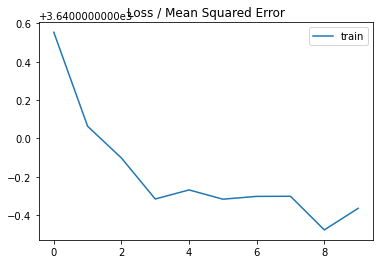

1563/1563 [==============================] - 3s 2ms/step
Simulation 0 of 50000 Simulations in re-hedging period 1 has been performed
Simulation 1000 of 50000 Simulations in re-hedging period 1 has been performed
Simulation 2000 of 50000 Simulations in re-hedging period 1 has been performed
Simulation 3000 of 50000 Simulations in re-hedging period 1 has been performed
Simulation 4000 of 50000 Simulations in re-hedging period 1 has been performed
Simulation 5000 of 50000 Simulations in re-hedging period 1 has been performed
Simulation 6000 of 50000 Simulations in re-hedging period 1 has been performed
Simulation 7000 of 50000 Simulations in re-hedging period 1 has been performed
Simulation 8000 of 50000 Simulations in re-hedging period 1 has been performed
Simulation 9000 of 50000 Simulations in re-hedging period 1 has been performed
Simulation 10000 of 50000 Simulations in re-hedging period 1 has been performed
Simulation 11000 of 50000 Simulations in re-hedging period 1 has been perfor

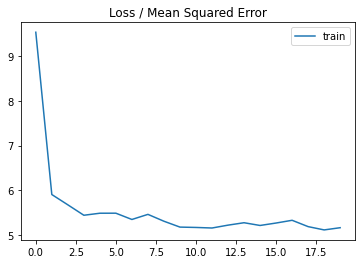

1563/1563 [==============================] - 3s 2ms/step
Compute Neural Network 1 in Re-hedging period: 0
Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 1)            4           input_10[0][0]                   
__________________________________________________________________________________________________
h-layer1 (Dense)                (None, 512)          1024        batch_normalization_18[0][0]     
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 512)          2048        h-layer1[0][0] 

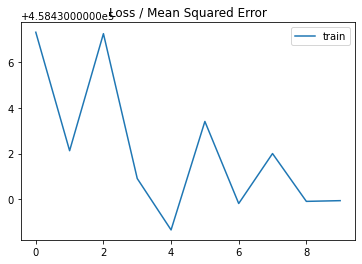

1563/1563 [==============================] - 3s 2ms/step
Simulation 0 of 50000 Simulations in re-hedging period 0 has been performed
Simulation 1000 of 50000 Simulations in re-hedging period 0 has been performed
Simulation 2000 of 50000 Simulations in re-hedging period 0 has been performed
Simulation 3000 of 50000 Simulations in re-hedging period 0 has been performed
Simulation 4000 of 50000 Simulations in re-hedging period 0 has been performed
Simulation 5000 of 50000 Simulations in re-hedging period 0 has been performed
Simulation 6000 of 50000 Simulations in re-hedging period 0 has been performed
Simulation 7000 of 50000 Simulations in re-hedging period 0 has been performed
Simulation 8000 of 50000 Simulations in re-hedging period 0 has been performed
Simulation 9000 of 50000 Simulations in re-hedging period 0 has been performed
Simulation 10000 of 50000 Simulations in re-hedging period 0 has been performed
Simulation 11000 of 50000 Simulations in re-hedging period 0 has been perfor

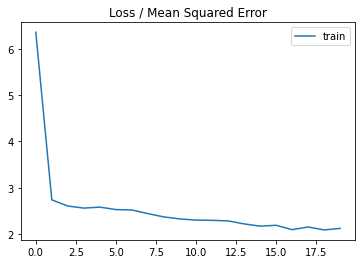

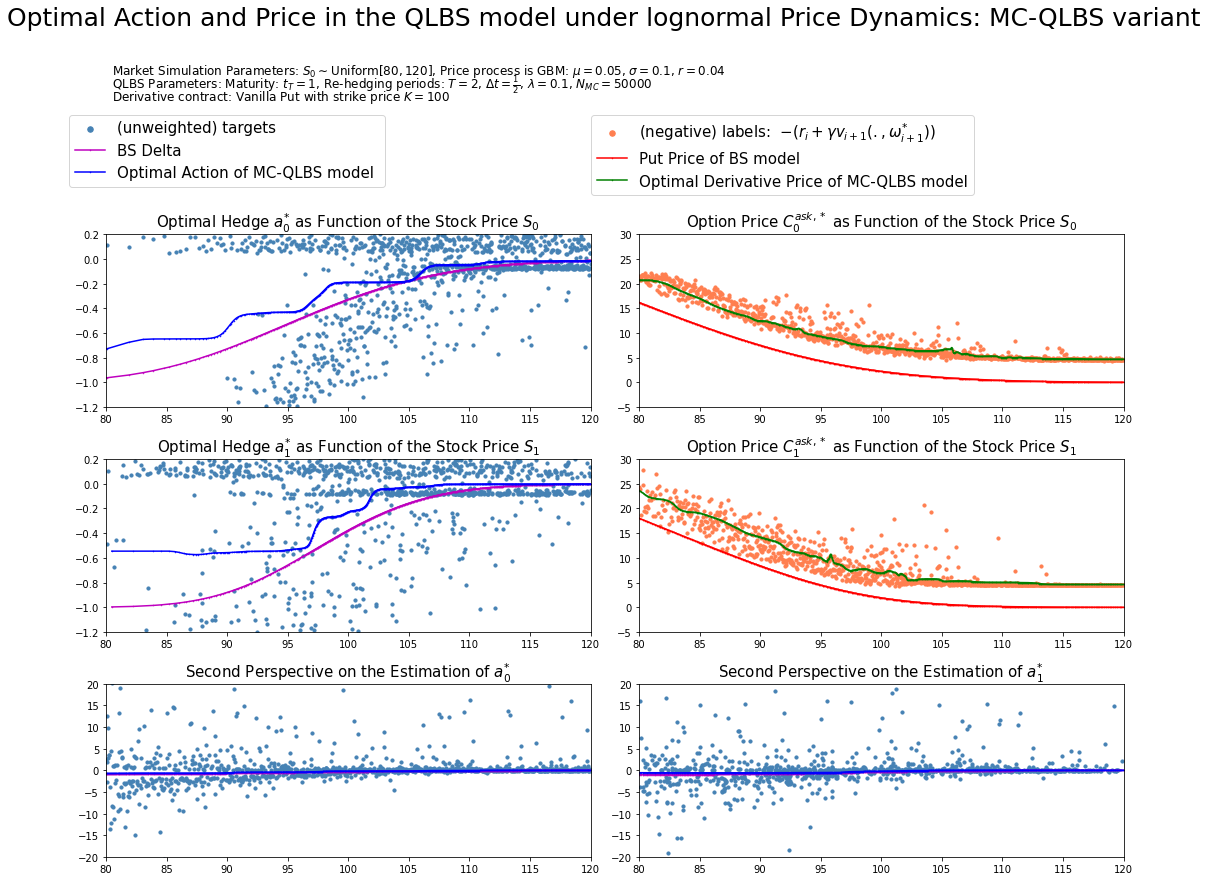

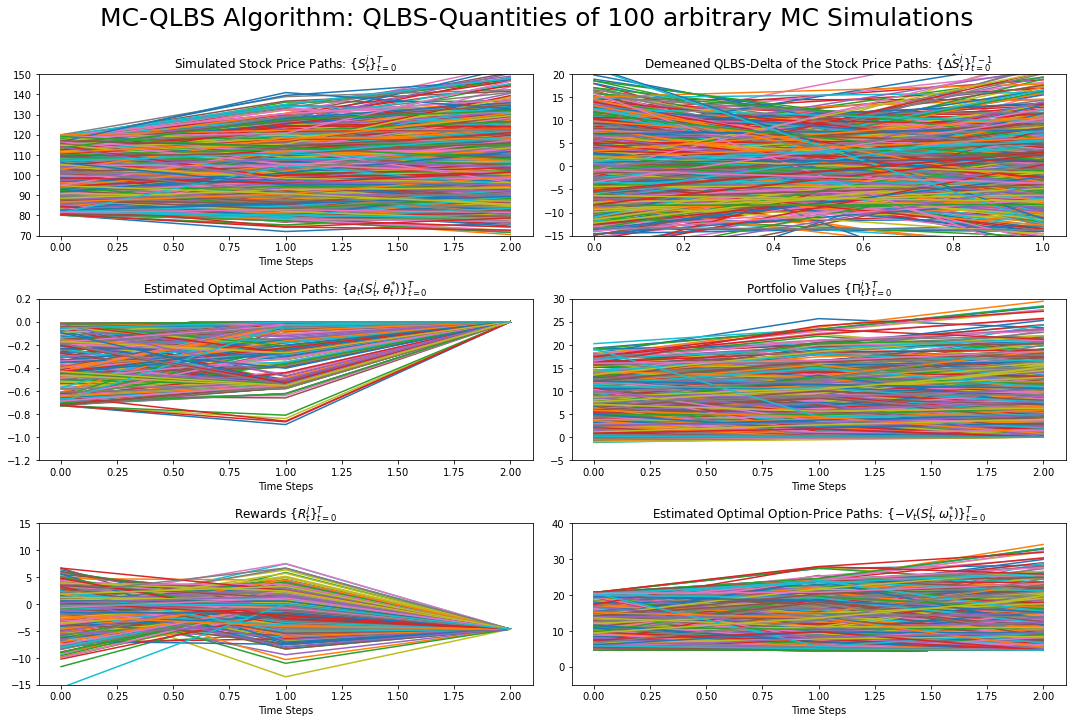

In [5]:
#Initialize parameter values:
mu = 0.05     # drift
r = 0.04      # risk-free rate
sigma = 0.1  # volatility
Ma = 1         # maturity
T = 2        # number of time steps -->weekly re-hedging
delta_t = Ma / T  #time between re-hedging periods
MC = 50000  # number of paths
gamma = np.exp(- r * delta_t)  # discount factor
lambda_par = 0.1 # risk aversion
K = 100             # option stike
#------------------------------------------------------------------------------------------------------------------
#Define Call- and Put functions/any European derivative to be priced here:
#Also, define BS Quantities to check convergence of the algorithm:
def payoff_put(ST, K):
    """"
    ST is maturity-stock price and K is strike
    """
    return max(K - ST, 0)

def payoff_call(ST, K):
    """"
    ST is maturity-stock price and K is strike
    """
    return max(ST - K, 0)

def payoffvec(ST,K):
    out = np.column_stack((K-ST,np.zeros((len(ST),1)))).max(axis = 1)
    return out

def EuCall_BlackScholes(t,S_t, r=r, sigma=sigma, T=Ma, K=K):
    d_1 = (math.log(S_t / K) + (r + 1 / 2 * math.pow(sigma, 2)) * (T-t)) / (sigma * math.sqrt(T-t))
    d_2 = d_1 - sigma * math.sqrt(T-t)
    phi = scipy.stats.norm.cdf(d_1)
    C = S_t * phi - K * math.exp(-r * (T-t)) * scipy.stats.norm.cdf(d_2)
    return C
def EuPut_BlackScholes(t,S_t, r=r, sigma=sigma, T=Ma, K=K):
    d_1 = (math.log(S_t / K) + (r + 1 / 2 * math.pow(sigma, 2)) * (T-t)) / (sigma * math.sqrt(T-t))
    d_2 = d_1 - sigma * math.sqrt(T-t)    
    phi = scipy.stats.norm.cdf(-d_2)
    C = K * np.exp(-r * (T-t)) * phi - S_t * scipy.stats.norm.cdf(-d_1)
    return C

def EuPut_BlackScholes_Delta(t,S_t, r=r, sigma=sigma, T=Ma, K=K):
    d_1 = (math.log(S_t / K) + (r + 1 / 2 * math.pow(sigma, 2)) * (T-t)) / (sigma * math.sqrt(T-t))
    return scipy.stats.norm.cdf(d_1) - 1
    
    
def EuCall_BlackScholes_Delta(t,S_t, r=r, sigma=sigma, T=Ma, K=K):
    d_1 = (math.log(S_t / K) + (r + 1 / 2 * math.pow(sigma, 2)) * (T-t)) / (sigma * math.sqrt(T-t))
    return scipy.stats.norm.cdf(d_1) 
#-----------------------------------------------------------------------------------------------------------------------


#-------------------------------------------------------------------------------------------------------------------------
#fill MC price path relalizations:
#initialize array-object (think of it to be a matrix)
S = pd.DataFrame([],index=range(MC),columns=range(T+1)) #frame-dimension: (MC,T+1)
#np.linspace(start=60, stop=140, num=MC)
S.loc[:,0] = np.random.uniform(low=80, high=120, size=(MC,1))
#Simulate stock prices as GBM: 
z = pd.DataFrame(np.random.randn(MC,T),index=range(MC),columns=range(1,T+1)) #dimension: (MC,T) of standard random numbers
#simulate the MC GBM's:
for t in range(1,T+1): #1,..,T
    S.loc[:,t] = np.multiply(S.loc[:,t-1],np.exp((mu - 1/2 * sigma**2)*delta_t + sigma * np.sqrt(delta_t) * z.loc[:,t])) 
#------------------------------------------------------------------------------------------------------------------------
#initialize for weighted MSE problem:
PI = pd.DataFrame([],index=range(MC),columns=range(T+1)) #(MC,T+1)
PI_hat = pd.DataFrame([],index=range(MC),columns=range(T+1)) #(MC,T+1)
dS = pd.DataFrame([],index=range(MC), columns=range(T)) #(MC,T)
dS_hat = pd.DataFrame([],index=range(MC), columns=range(T)) #(MC,T)
#store to MC data corresponding optimal action approximation
a_star = pd.DataFrame([],index=range(MC),columns=range(T+1)) #(N_MC,T+1)
R = pd.DataFrame([],index=range(MC),columns=range(T+1)) #empty (N_MC,T+1)


#compute target and weights for first weighted MSE problem 
a_star.iloc[:,-1] = 0 #by def
dS = S.loc[:,1:T].values - np.exp(r * delta_t) * S.loc[:,0:(T-1)].values
dS = pd.DataFrame(data=dS, index=range(MC),columns=range(T))
dS_hat = dS - np.mean(dS,axis=0)
PI.loc[:,T] = S.loc[:,T].apply(lambda x: payoff_put(x,K))
PI_hat.loc[:,T] = PI.loc[:,T] - np.mean(PI.loc[:,T])
R.iloc[:,-1] = - lambda_par * np.var(PI.iloc[:,-1],ddof=1)

#---------------------------------------------------------------------------------------------------------------------
#step T-1
#define the (deep) neural network under weighted MSE loss using keras functional API
#custom activation to exploit knowledge - not preferred, should work for linear activation in output layer!
print('Compute Neural Network 1 in Re-hedging period:',T-1)
def custom_activation(x):
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    act = ((tf.math.sigmoid(x) -1/2) - 1/2) 
    act = tf.convert_to_tensor(act, dtype=tf.float32)
    return act

input_layer = layers.Input(shape =(1,)) # S 
normalized_input = layers.BatchNormalization()(input_layer)
#normalized_input = layers.Dropout(0.1)(normalized_input)
hidden_layer1 = layers.Dense(units=2**9, activation='tanh',name='h-layer1')(normalized_input)
normalized_h1 = layers.BatchNormalization()(hidden_layer1)
#no dropout
hidden_layer2 = layers.Dense(units=2**8, activation='tanh',name='h-layer2')(normalized_h1)
normalized_h2 = layers.BatchNormalization()(hidden_layer2)
hidden_layer3 = layers.Dense(units=2**7, activation='tanh',name='h-layer3')(normalized_h2)
#no dropout before last layer
out1 = layers.Dense(units = 1, activation=custom_activation,name = 'output-layer1')(hidden_layer3)

# Two additional 'inputs' for the labels
target_layer_1 = layers.Input(shape = (1,))
weight_layer_2 = layers.Input(shape = (1,))

model = keras.Model(inputs=[input_layer,target_layer_1,weight_layer_2],outputs=[out1])
print(model.summary())    
# Construct custom loss as a tensor
loss = tf.math.reduce_mean(keras.losses.mse(tf.math.multiply(out1, weight_layer_2) , target_layer_1))

# Add loss to model
model.add_loss(loss)

# compile the keras model
model.compile(optimizer='adam')
#--------------------------------------------------------------------------------------------------------------------
#get NN input data: target, weight
y = np.add(np.divide(dS[T-1], np.multiply(2*lambda_par*gamma,dS_hat[T-1])), PI_hat[T]).values.reshape(-1,1) 
#replace y with the following y when the term with lambda in denomiator of weighted MSE loss is discarded
#y = PI_hat[T].values.reshape(-1,1)
weight = dS_hat[T-1].values.reshape(-1,1)
X = S[T-1].values.reshape(-1,1)
#-------------------------------------------------------------------------------------------------------------------
#train the model
dummy = np.zeros((MC,1))
history = model.fit([X,y,weight],dummy, epochs=10, batch_size=12,verbose = 1,shuffle=True)    
    
#evaluate the model
train_mse = model.evaluate([X,y,weight],dummy,verbose=1)
print('Train: %.3f' % (train_mse))
#plot loss during training
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show() 
#-------------------------------------------------------------------------------------------------------------------
#for figure of QLBS-Quantities:
#use new model to compute a*, PI, PI_hat
a_star.loc[:,T-1]  = model.predict([X,y,weight], verbose = 1)
#Initialize parameters for second Neural Network
PI.loc[:,T-1] = gamma * (PI.loc[:,T].values - a_star.loc[:,T-1].values * dS.loc[:,T-1].values)
PI_hat.loc[:,T-1] = PI.loc[:,T-1] - np.mean(PI.loc[:,T-1]) 
#--------------------------------------------------------------------------------------------------------------------
#get target data for pure MSE problem (second estimation of MC-QLBS)
V = pd.DataFrame([], index=range(MC), columns=range(T+1)) #(N_MC,T+1)
V.loc[:,T] = -PI.loc[:,T] - lambda_par * np.var(PI.loc[:,T], ddof=1)
#--------------------------------------------------------------------------------------------------------------------
#perform MC-QLBS function approximation:

#re-hedging period T-1: generate the training data for second regression:
x_batch, y_batch = [], [] # store the training data in
for i in range(MC):
    if i % 1000 == 0: print("Simulation {} of {} Simulations in re-hedging period {} has been performed".format(i,MC,T-1))
    ST = S.loc[i,T-1] * np.exp((mu - 1/2 * sigma**2)*delta_t + sigma * np.sqrt(delta_t) * np.random.randn(50,1)) 
    ind = random.sample(range(50),1)[0]
    x_batch.append(S.loc[i,T-1])
    
    PITmin1 = gamma * (np.column_stack((K-ST,np.zeros((50,1)))).max(axis = 1) - (a_star.loc[i,T-1] * (ST - np.exp(r * delta_t)*S.loc[i,T-1])).reshape(-1))
   #RTmin1 = gamma * a_star.loc[i,T-1] * (ST[ind] - np.exp(r * delta_t) * S.loc[i,T-1]) - lambda_par * np.var(PITmin1,ddof=1)  
   
    R.loc[i,T-1] = gamma * a_star.loc[i,T-1] * (S.loc[i,T] - np.exp(r * delta_t) * S.loc[i,T-1]) - lambda_par * np.var(PITmin1,ddof=1)   
    
    label = R.loc[i,T-1] + gamma * V.loc[i,T]
    y_batch.append(label)
#------------------------------------------------------------------------------------------------------------------------
#compile the keras model for second regression
print('Compute Neural Network 2 in Re-hedging period:',t)
model2 = keras.Sequential()
model2.add(layers.BatchNormalization(input_shape=(1,)))
#model2.add(layers.Dropout(0.1))
model2.add(layers.Dense(2**9, input_shape=(1,), activation='tanh', name = 'h-layer1'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dense(2**8, activation='tanh', name ='h-layer2'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dense(2**7, activation='tanh', name ='h-layer3'))
#no dropout before last layer
model2.add(layers.Dense(1, activation='linear',name = 'output-layer'))
# compile the keras model
model2.compile(loss='mse', optimizer='adam')
print(model2.summary()) 
#----------------------------------------------------------------------------------------------------------------------
#fit the model of V_T-1 using the computed training data:
history = model2.fit(np.array(x_batch), np.array(y_batch),epochs = 20, batch_size=32, verbose=1, shuffle = True) 

#evaluate the model
train_mse = model2.evaluate(np.array(x_batch),np.array(y_batch))
print('Train: %.3f' % (train_mse))
    
#plot loss during training
plt.figure(0)
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show() 
#--------------------------------------------------------------------------------------------------------------------
#estimate the state value function values for each MC simulation:
V.loc[:,T-1] = model2.predict(np.array(S.loc[:,T-1]), verbose = 1)
#----------------------------------------------------------------------------------------------------------------------
#first look at model performance relative to BS quantities: CAN BE IGNORED - BETTER FIGURE SHOWN LATER!
#numpy_data = np.array([S[T-1].values.reshape(-1),y.reshape(-1),weight.reshape(-1),-V[T-1].values.reshape(-1)])
#df = pd.DataFrame(data=numpy_data.T, index=range(MC),columns=range(4))
#df = df.sort_values([0]) 
#a_star_predict = model.predict([df.loc[:,0].values.reshape(-1,1),df.loc[:,1].values.reshape(-1,1),df.loc[:,2].values.reshape(-1,1)],verbose = 1)
#df[4] = a_star_predict
#print(df)
#rnumb = len(df.loc[:,0].values)
#BSPutDelta = np.empty((rnumb,1), dtype=float) #6 columns for T multiple of 6
#BSPut = np.empty((rnumb,1), dtype = float)
#QLBS_GBM_action = np.empty((rnumb,1), dtype=float)
#time = (T-1)/T
#for i in range(rnumb):
#        BSPutDelta[i,0] = EuPut_BlackScholes_Delta(time, df.loc[:,0].values[i], r=r, sigma=sigma, T=Ma, K=K)
#        #QLBS_GBM_action[i,0] = BSPutDelta[i,0] + (mu - r)/(2 * lambda_par * sigma**2 * df.loc[:,0].values[i])
#        BSPut[i,0] = EuPut_BlackScholes(time,df.loc[:,0].values[i], r=r, sigma=sigma, T=Ma, K=K)
        
#plt.figure(1)        
#plt.plot(df.loc[:,0],df[4],color= 'red',marker='+',markersize=1, label = r'Optimal Action under B-Splines in QLBS: $a(s_{i},\phi_{t}^{*})=\phi_{t}^{*,T}\Phi(s_{t})$ ') 
#plt.plot(df.loc[:,0],BSPutDelta[:,0],color = 'black', label = 'BS-Put-Delta:$ \frac{\partialC}{\partial S_{t}}$',marker='+',markersize=1)
#plt.xlim(70, 130) 
#plt.show()
    
#plt.figure(2)
#plt.plot(df.loc[:,0],df.loc[:,3],'.',linewidth = 0.5,color= 'red', label = r'Optimal Action under B-Splines in QLBS: $a(s_{i},\phi_{t}^{*})=\phi_{t}^{*,T}\Phi(s_{t})$ ') 
#plt.plot(df.loc[:,0],BSPut[:,0],color = 'black', label = 'BS-Put-Delta:$ \frac{\partialC}{\partial S_{t}}$',marker='+',markersize=1)
#plt.xlim(70, 130) 
#plt.show()
    
#plt.figure(3)
#plt.plot(df[0],df[1]/ df[2],'.',color='blue')
#plt.plot(df[0],df[4],'.',color='red')
#plt.xlim(70, 130) 
#plt.ylim(-70,70)
#plt.show()
#-----------------------------------------------------------------------------------------------------------------------
#compile action-network in re-hedging period T-2
#define the (deep) neural network under weighted MSE loss using keras functional API
#custom activation to exploit knowledge - not preferred, should work (and does) for linear activation in output layer!
print('Compute Neural Network 1 in Re-hedging period:',T-2)

input_layer = layers.Input(shape =(1,)) # S 
normalized_input = layers.BatchNormalization()(input_layer)
#normalized_input = layers.Dropout(0.1)(normalized_input)
hidden_layer1 = layers.Dense(units=2**9, activation='tanh',name='h-layer1')(normalized_input)
normalized_h1 = layers.BatchNormalization()(hidden_layer1)
#no dropout
hidden_layer2 = layers.Dense(units=2**8, activation='tanh',name='h-layer2')(normalized_h1)
normalized_h2 = layers.BatchNormalization()(hidden_layer2)
hidden_layer3 = layers.Dense(units=2**7, activation='tanh',name='h-layer3')(normalized_h2)
#no dropout before last layer
out1 = layers.Dense(units = 1, activation=custom_activation,name = 'output-layer1')(hidden_layer3)

# Two additional 'inputs' for the labels
target_layer_1 = layers.Input(shape = (1,))
weight_layer_2 = layers.Input(shape = (1,))

model3 = keras.Model(inputs=[input_layer,target_layer_1,weight_layer_2],outputs=[out1])
print(model3.summary())    
# Construct custom loss as a tensor
loss = tf.math.reduce_mean(keras.losses.mse(tf.math.multiply(out1, weight_layer_2) , target_layer_1))

# Add loss to model
model3.add_loss(loss)

# compile the keras model
model3.compile(optimizer='adam')
#---------------------------------------------------------------------------------------------------------------------
#get action-network input data: target, weight
y = np.add(np.divide(dS[T-2], np.multiply(2*lambda_par*gamma,dS_hat[T-2])), PI_hat[T-1]).values.reshape(-1,1) 
#For lambda-dependent term in weighted MSE set to zero: replace above y by below y-definition
#y = PI_hat[T-1].values.reshape(-1,1)
weight = dS_hat[T-2].values.reshape(-1,1)
X = S[T-2].values.reshape(-1,1)
#-------------------------------------------------------------------------------------------------------------------
#train the action network of period T-2:
history = model3.fit([X,y,weight],dummy, epochs=10, batch_size=12,verbose = 1,shuffle=True)    
    
# evaluate the model
train_mse = model3.evaluate([X,y,weight],dummy,verbose=1)
print('Train: %.3f' % (train_mse))
# plot loss during training
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show() 
#-------------------------------------------------------------------------------------------------------------------
#use new model to compute QLBS-quantities for plot 
a_star.loc[:,T-2]  = model3.predict([X,y,weight], verbose = 1)
PI.loc[:,T-2] = gamma * (PI.loc[:,T-1].values - a_star.loc[:,T-2].values * dS.loc[:,T-2].values)
PI_hat.loc[:,T-2] = PI.loc[:,T-2] - np.mean(PI.loc[:,T-2]) 
#------------------------------------------------------------------------------------------------------------------
#re-hedging period T-2: simulate training data for training second neural network that estimate state value function:
x_batch, y_batch = [], [] # store the training data in
for i in range(MC):
    if i % 1000 == 0: print("Simulation {} of {} Simulations in re-hedging period {} has been performed".format(i,MC,T-2))
    STmin1 = S.loc[i,T-2] * np.exp((mu - 1/2 * sigma**2)*delta_t + sigma * np.sqrt(delta_t) * np.random.randn(50,1)) 
    ST = STmin1 * np.exp((mu - 1/2 * sigma**2)*delta_t + sigma * np.sqrt(delta_t) * np.random.randn(50,1)) 
    ind = random.sample(range(50),1)[0]
    x_batch.append(S.loc[i,T-2])
    #get y,weight,X --> compute PITmin1
    dSTmin1 = ST - np.exp(r * delta_t) * STmin1
    dSTmin1hat = dSTmin1 - np.mean(dSTmin1)
    PIT = np.column_stack((K-ST,np.zeros((50,1)))).max(axis = 1)
    y = np.add(np.divide(dSTmin1, np.multiply(2*lambda_par*gamma,dSTmin1hat)), PIT.reshape(-1,1))
    #replace above y with below y when lambda-dependent term in weighted MSE is set to zero
    #y = PIT.reshape(-1,1)
        
    PITmin1 = gamma * (np.column_stack((K-ST,np.zeros((50,1)))).max(axis = 1) - (model.predict([STmin1,y,dSTmin1hat], verbose = 0) * (ST - np.exp(r * delta_t)*STmin1)).reshape(-1))    
    PITmin2 = gamma * (PITmin1 - (a_star.loc[i,T-2] * (STmin1 - np.exp(r * delta_t)*S.loc[i,T-2])).reshape(-1))
    
    #RTmin2 = gamma * a_star.loc[i,T-2] * (STmin1[ind] - np.exp(r * delta_t) * S.loc[i,T-2]) - lambda_par * np.var(PITmin2,ddof=1)  
    
    R.loc[i,T-2] = gamma * a_star.loc[i,T-2] * (S.loc[i,T-1] - np.exp(r * delta_t) * S.loc[i,T-2]) - lambda_par * np.var(PITmin2,ddof=1)
    
    label = R.loc[i,T-2] + gamma * V.loc[i,T-1]
    y_batch.append(label)
#-------------------------------------------------------------------------------------------------------------------
#define the keras model for V_T-2 
print('Compute Neural Network 2 in Re-hedging period:',t)
model4 = keras.Sequential()
model4.add(layers.BatchNormalization(input_shape=(1,)))
#model4.add(layers.Dropout(0.1))
model4.add(layers.Dense(2**9, input_shape=(1,), activation='tanh', name = 'h-layer1'))
model4.add(layers.BatchNormalization())
model4.add(layers.Dense(2**8, activation='tanh', name ='h-layer2'))
model4.add(layers.BatchNormalization())
model4.add(layers.Dense(2**7, activation='tanh', name ='h-layer3'))
#no dropout before last layer
model4.add(layers.Dense(1, activation='linear',name = 'output-layer'))
# compile the keras model
model4.compile(loss='mse', optimizer='adam')
print(model4.summary()) 
#----------------------------------------------------------------------------------------------------------------
#fit the keras model for V_T-2 
history = model4.fit(np.array(x_batch), np.array(y_batch),epochs = 20, batch_size=32, verbose=1, shuffle = True) 

#evaluate the model
train_mse = model4.evaluate(np.array(x_batch),np.array(y_batch))
print('Train: %.3f' % (train_mse))
    
#plot loss during training
plt.figure(0)
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show() 
#---------------------------------------------------------------------------------------------------------------
#predict the state value for MC data at re-hedging period T-2
V.loc[:,T-2] = model4.predict(np.array(x_batch))
#---------------------------------------------------------------------------------------------------------------
#create Figures of MC-QLBS algorithms to illustrate convergence to BS-Quantities
#set number of scatter points to be plotted
plotpoints = 1000
BSPutDelta = np.empty((plotpoints,2), dtype=float) 
BSPut = np.empty((plotpoints,2), dtype = float)
BSPutDelta2 = np.empty((plotpoints,2), dtype=float) 

#replace target_aTmin1 and target_a0 with other ones here when lambda-dependent term is set to zero
target_aTmin1 = np.add(np.divide(dS[T-1], np.multiply(2*lambda_par*gamma,np.square(dS_hat[T-1]))), np.divide(PI_hat[T],dS_hat[T-1])).values.reshape(-1,1)
#target_aTmin1 = np.divide(PI_hat[T],dS_hat[T-1]).values.reshape(-1,1)
target_a0 = np.add(np.divide(dS[T-2], np.multiply(2*lambda_par*gamma,np.square(dS_hat[T-2]))), np.divide(PI_hat[T-1],dS_hat[T-2])).values.reshape(-1,1)
#target_a0 = np.divide(PI_hat[T-1],dS_hat[T-2]).values.reshape(-1,1)


#choose plotpoints observations out ob MC-data where quantities to be plotted are in the x- and y-axis range
#otherwise there will be problems to import the figure in latex 
test1 = np.logical_and(np.where(target_a0 > -1.2, True, False), np.where(target_a0 < 0.2, True, False))
test1 = np.logical_and(test1, np.where(S[0] > 80, True,False).reshape(-1,1))
test1 = np.logical_and(test1, np.where(S[0] < 120, True,False).reshape(-1,1))
inindex1 = np.where(test1)[0] 
indexobs1 = S[0][inindex1].sort_values().index 

test2 = np.logical_and( np.where(S[0] > 80, True,False).reshape(-1,1), np.where(S[0] < 120, True,False).reshape(-1,1))
test2 = np.logical_and(test2, np.where((-R[0]-gamma * V[1])> -5, True, False).reshape(-1,1))
test2 = np.logical_and(test2, np.where((-R[0]-gamma * V[1])< 30, True, False).reshape(-1,1))
inindex2 = np.where(test2)[0] 
indexobs2 = S[0][inindex2].sort_values().index 

test3 = np.logical_and(np.where(target_aTmin1 > -1.2, True, False), np.where(target_aTmin1 < 0.2, True, False))
test3 = np.logical_and(test3, np.where(S[T-1] > 80, True,False).reshape(-1,1))
test3 = np.logical_and(test3, np.where(S[T-1] < 120, True,False).reshape(-1,1))
inindex3 = np.where(test3)[0] 
indexobs3 = S[T-1][inindex3].sort_values().index 

test4 = np.logical_and(np.where(S[T-1] < 120, True,False).reshape(-1,1), np.where(S[T-1] > 80, True,False).reshape(-1,1))
test4 = np.logical_and(test4, np.where((-R[T-1] - gamma * V[T])> -5, True,False).reshape(-1,1))
test4 = np.logical_and(test4, np.where((-R[T-1] - gamma * V[T]) < 30, True,False).reshape(-1,1))
inindex4 = np.where(test4)[0] 
indexobs4 = S[T-1][inindex4].sort_values().index 


test5 = np.logical_or(np.where(target_a0 > -20, True, False), np.where(target_a0 < 20, True, False)) #see the or!
test5 = np.logical_and(test5, np.where(S[0] > 80, True,False).reshape(-1,1))
test5 = np.logical_and(test5, np.where(S[0] < 120, True,False).reshape(-1,1))
inindex5 = np.where(test5)[0] 
indexobs5 = S[0][inindex5].sort_values().index 

test6 = np.logical_or(np.where(target_aTmin1 > -20, True, False), np.where(target_aTmin1 < 20, True, False)) #notice or
test6 = np.logical_and(test6, np.where(S[T-1] > 80, True,False).reshape(-1,1))
test6 = np.logical_and(test6, np.where(S[T-1] < 120, True,False).reshape(-1,1))
test6 = np.logical_and(test6, np.where((-R[T-1] - gamma * V[T])> -5, True,False).reshape(-1,1))
test6 = np.logical_and(test6, np.where((-R[T-1] - gamma * V[T]) < 30, True,False).reshape(-1,1))
inindex6 = np.where(test6)[0] 
indexobs6 = S[T-1][inindex6].sort_values().index 


tcf1 = len(indexobs1)
tcf2 = len(indexobs2)
tcf3 = len(indexobs3)
tcf4 = len(indexobs4)
tcf5 = len(indexobs5)
tcf6 = len(indexobs6)

idx1 = np.round(np.linspace(0,tcf1 - 1 , plotpoints)).astype(int)
idx2 = np.round(np.linspace(0,tcf2 - 1 , plotpoints)).astype(int)
idx3 = np.round(np.linspace(0,tcf3 - 1 , plotpoints)).astype(int)
idx4 = np.round(np.linspace(0,tcf4 - 1 , plotpoints)).astype(int)
idx5 = np.round(np.linspace(0,tcf5 - 1 , plotpoints)).astype(int)
idx6 = np.round(np.linspace(0,tcf6 - 1 , plotpoints)).astype(int)

indexobs1 = indexobs1[idx1]
indexobs2 = indexobs2[idx2]
indexobs3 = indexobs3[idx3]
indexobs4 = indexobs4[idx4]
indexobs5 = indexobs5[idx5]
indexobs6 = indexobs6[idx6]

#compute the respective BS quantities for the plots for each re-hedging step 0,..,T-1:
for t in [0,T-1]: 
    time = t * delta_t
    if t == 0: 
        col = 0
        prices1 = S.iloc[indexobs1,0].values
        prices2 = S.iloc[indexobs2,0].values 
        prices3 = S.iloc[indexobs5,0].values 
    else: 
        col = 1
        prices1 = S.iloc[indexobs3,T-1].values
        prices2 = S.iloc[indexobs4,T-1].values
        prices3 = S.iloc[indexobs6,T-1].values 
        #prices2 = S.iloc[indexobs4,T-1].values       
    for i in range(plotpoints):
        BSPutDelta[i,col] = EuPut_BlackScholes_Delta(time, prices1[i], r=r, sigma=sigma, T=Ma, K=K)
        BSPutDelta2[i,col] = EuPut_BlackScholes_Delta(time, prices3[i], r=r, sigma=sigma, T=Ma, K=K)       
        BSPut[i,col] = EuPut_BlackScholes(time,prices2[i], r=r, sigma=sigma, T=Ma, K=K)
        
figu,ax = plt.subplots(nrows=3,ncols=2,figsize=(15,10))
figu.suptitle(r'Optimal Action and Price in the QLBS model under lognormal Price Dynamics: MC-QLBS variant',fontsize=25, x = 0.5, y = 1.22)


ax[0, 0].scatter(S.iloc[indexobs1,0],target_a0[indexobs1],color= 'steelblue',marker='o', s=10,label = r'(unweighted) targets')
ax[0, 0].plot(S.iloc[indexobs1,0],BSPutDelta[:,0],color = 'm', label = r'BS Delta',marker='.',markersize=1)
ax[0, 0].plot(S.iloc[indexobs1,0],a_star.iloc[indexobs1,0],color= 'blue',marker='.',markersize=1, label = r'Optimal Action of MC-QLBS model ') 
#ax[0, 0].plot(S_tvec,QLBS_GBM_action[:,0],color = 'green', label =r'BS-Put-Delta + $ \frac{\mu - r}{2\lambda\sigma^{2}S_{t}}$')
ax[0, 0].set_title(r'Optimal Hedge $a_{0}^{*}$ as Function of the Stock Price $S_{0}$',fontsize=15, loc ='center')
ax[0, 0].set_ylim([-1.2, 0.2])
ax[0, 0].set_xlim([80, 120])

ax[0, 1].scatter(S.iloc[indexobs2,0],-R.iloc[indexobs2,0] - gamma * V.loc[indexobs2,1],color = 'coral',marker='o', s=10, label =r'(negative) labels:  $- (r_{i} + \gamma v_{i+1}(.,\omega_{i+1}^{*})) $ ' )
ax[0, 1].plot(S.iloc[indexobs2,0],BSPut[:,0],color = 'red', label = r'Put Price of BS model',marker='.',markersize=1)
ax[0, 1].plot(S.iloc[indexobs2,0],-V.loc[indexobs2,0],color= 'green',marker='.',markersize=1, label = r'Optimal Derivative Price of MC-QLBS model') 
#ax[0, 0].plot(S_tvec,QLBS_GBM_action[:,0],color = 'green', label =r'BS-Put-Delta + $ \frac{\mu - r}{2\lambda\sigma^{2}S_{t}}$')
ax[0, 1].set_title(r'Option Price $C_{0}^{ask,*}$ as Function of the Stock Price $S_{0}$',fontsize=15, loc ='center')
ax[0, 1].set_ylim([-5, 30])
ax[0, 1].set_xlim([80, 120])

ax[1, 0].scatter(S.iloc[indexobs3,0],target_aTmin1[indexobs3],color= 'steelblue',marker='o', s=10,label = r'unweighted labels: $ \hat{\Pi}_{i}/\Delta \hat{S_{i}} $')
ax[1, 0].plot(S.iloc[indexobs3,T-1],BSPutDelta[:,1],color = 'm', label = r'BS-Put-Delta: $\frac{\partial C}{\partial S_{t}}$',marker='.',markersize=1)
ax[1, 0].plot(S.iloc[indexobs3,T-1],a_star.iloc[indexobs3,T-1],color= 'blue',marker='.',markersize=1, label = r'Optimal Action in QLBS using neural networks: $a(.,\theta_{0}^{*})$ ') 
#ax[1, 0].plot(S_tvec,QLBS_GBM_action[:,0],color = 'green', label =r'BS-Put-Delta + $ \frac{\mu - r}{2\lambda\sigma^{2}S_{t}}$')
ax[1, 0].set_title(r'Optimal Hedge $a_{1}^{*}$ as Function of the Stock Price $S_{1}$',fontsize=15, loc ='center')
ax[1, 0].set_ylim([-1.2, 0.2])
ax[1, 0].set_xlim([80, 120])

ax[1, 1].scatter(S.iloc[indexobs4,T-1],-R.iloc[indexobs4,T-1] - gamma * V.loc[indexobs4,T],color = 'coral',marker='o', s=10, label =r'(negative) labels:  $- (R_{0} + \gamma V) $ ' )
ax[1, 1].plot(S.iloc[indexobs4,T-1],BSPut[:,1],color = 'red', label = r'BS-Put-Delta: $\frac{\partial C}{\partial S_{t}}$',marker='.',markersize=1)
ax[1, 1].plot(S.iloc[indexobs4,T-1],-V.loc[indexobs4,T-1],color= 'green',marker='.',markersize=1, label = r'Optimal Derivative Price in QLBS: $C_{0}^{ask,*}$ ') 
#ax[1, 0].plot(S_tvec,QLBS_GBM_action[:,0],color = 'green', label =r'BS-Put-Delta + $ \frac{\mu - r}{2\lambda\sigma^{2}S_{t}}$')
ax[1, 1].set_title(r'Option Price $C_{1}^{ask,*}$ as Function of the Stock Price $S_{1}$',fontsize=15, loc ='center')
ax[1, 1].set_ylim([-5, 30])
ax[1, 1].set_xlim([80, 120])

ax[2, 0].scatter(S.iloc[indexobs5,0],target_a0[indexobs5],color= 'steelblue',marker='o', s=10,label = r'(unweighted) targets')
ax[2, 0].plot(S.iloc[indexobs5,0],BSPutDelta2[:,0],color = 'm', label = r'BS Delta',marker='.',markersize=1)
ax[2, 0].plot(S.iloc[indexobs5,0],a_star.iloc[indexobs5,0],color= 'blue',marker='.',markersize=1, label = r'Optimal Action of MC-QLBS model ') 
#ax[0, 0].plot(S_tvec,QLBS_GBM_action[:,0],color = 'green', label =r'BS-Put-Delta + $ \frac{\mu - r}{2\lambda\sigma^{2}S_{t}}$')
ax[2, 0].set_title(r'Second Perspective on the Estimation of $a_{0}^{*}$',fontsize=15, loc ='center')
ax[2, 0].set_ylim([-20, 20])
ax[2, 0].set_xlim([80, 120])

ax[2, 1].scatter(S.iloc[indexobs6,0],target_aTmin1[indexobs6],color= 'steelblue',marker='o', s=10,label = r'unweighted labels: $ \hat{\Pi}_{i}/\Delta \hat{S_{i}} $')
ax[2, 1].plot(S.iloc[indexobs6,T-1],BSPutDelta2[:,1],color = 'm', label = r'BS-Put-Delta: $\frac{\partial C}{\partial S_{t}}$',marker='.',markersize=1)
ax[2, 1].plot(S.iloc[indexobs6,T-1],a_star.iloc[indexobs6,T-1],color= 'blue',marker='.',markersize=1, label = r'Optimal Action in QLBS using neural networks: $a(.,\theta_{0}^{*})$ ') 
#ax[1, 0].plot(S_tvec,QLBS_GBM_action[:,0],color = 'green', label =r'BS-Put-Delta + $ \frac{\mu - r}{2\lambda\sigma^{2}S_{t}}$')
ax[2, 1].set_title(r'Second Perspective on the Estimation of $a_{1}^{*}$',fontsize=15, loc ='center')
ax[2, 1].set_ylim([-20, 20])
ax[2, 1].set_xlim([80, 120])

handles, labels = ax[0,0].get_legend_handles_labels()
lgnd = figu.legend(handles, labels,  bbox_to_anchor=(-0.296, 0.38, 0.6, 0.7), prop={'size': 15})
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]

handles, labels = ax[0,1].get_legend_handles_labels()
lgnd2 = figu.legend(handles, labels,  bbox_to_anchor=(0.2497, 0.38, 0.6, 0.7), prop={'size': 15})
lgnd2.legendHandles[0]._sizes = [30]
lgnd2.legendHandles[1]._sizes = [30]
lgnd2.legendHandles[2]._sizes = [30]
plt.tight_layout()
plt.text(36.5, 161.0, r'Market Simulation Parameters: $S_{0}\sim\mathrm{Uniform}[80,120]$, Price process is GBM: $\mu =0.05$, $\sigma = 0.1$, $r=0.04$', fontsize=12)
plt.text(36.5, 158.0, r'QLBS Parameters: Maturity: $t_{T}=1$, Re-hedging periods: $T=2$, $\Delta t=\frac{1}{2}$, $\lambda = 0.1$, $N_{MC}=50000$', fontsize=12)
plt.text(36.5, 155.0, r'Derivative contract: Vanilla Put with strike price $K=100$', fontsize=12)

#plt.savefig('NN-MCpart1.pgf', bbox_inches='tight')

#-------------------------------------------------------------------------------------------------------------------
# plot: Simulated data for N MC paths:

N = 1000

f, axarr = plt.subplots(3, 2, figsize=(15,10))
f.suptitle(r'MC-QLBS Algorithm: QLBS-Quantities of 100 arbitrary MC Simulations',fontsize=25, x = 0.5, y = 1)


axarr[0, 0].plot(S.T.iloc[:,list(range(N))], label = r'Stock price paths: $\{S_{t}^{j}\}_{t=0}^{T}$') #[1,2,3,4,5,6,7,8,9,10]
axarr[0, 0].set_xlabel('Time Steps')
axarr[0, 0].set_title(r'Simulated Stock Price Paths: $\{S_{t}^{j}\}_{t=0}^{T}$')
axarr[0, 0].set_ylim([70, 150])

axarr[0, 1].plot(dS_hat.T.iloc[:,list(range(N))], label = r'QLBS-Quantity $\hat{\Delta S}_t$') #[1,2,3,4,5,6,7,8,9,10]
axarr[0, 1].set_xlabel('Time Steps')
axarr[0, 1].set_title(r'Demeaned QLBS-Delta of the Stock Price Paths: $\{\hat{\Delta S}_{t}^{j}\}_{t=0}^{T-1}$')
axarr[0, 1].set_ylim([-15, 20])

axarr[1, 0].plot(a_star.T.iloc[:,list(range(N))]) 
axarr[1, 0].set_xlabel('Time Steps')
axarr[1, 0].set_title(r'Estimated Optimal Action Paths: $\{a_{t}(S_{t}^{j},\theta_{t}^{*})\}_{t=0}^{T}$')
axarr[1, 0].set_ylim([-1.2, 0.2])

axarr[1, 1].plot(PI.T.iloc[:,list(range(N))]) 
axarr[1, 1].set_xlabel('Time Steps')
axarr[1, 1].set_title(r'Portfolio Values $\{\Pi_{t}^{j}\}_{t=0}^{T}$')
axarr[1, 1].set_ylim([-5, 30])

axarr[2, 0].plot(R.T.iloc[:,list(range(N))]) 
axarr[2, 0].set_xlabel('Time Steps')
axarr[2, 0].set_title(r'Rewards $\{R_{t}^{j}\}_{t=0}^{T}$') 
axarr[2, 0].set_ylim([-15, 15])

axarr[2, 1].plot(-V.T.iloc[:,list(range(N))]) 
axarr[2, 1].set_xlabel('Time Steps')
axarr[2, 1].set_title(r'Estimated Optimal Option-Price Paths: $\{-V_{t}(S_{t}^{j},\omega_{t}^{*})\}_{t=0}^{T}$')
axarr[2, 1].set_ylim([-5, 40])

plt.tight_layout()
#plt.savefig('NN-MCpart2.pgf', bbox_inches='tight')